In [16]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import re # to access database details in a file
import time # to time how long queries and processes take
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta # to manipulate dates


% matplotlib inline

In [17]:
path='/Users/brianna/Documents/WL_DBdeets/'

In [18]:
def connect_db(which_db):
    # Grab the details from a text file for how to access the database
    db_file = open(path+which_db+'DBdeets.txt','r')
    db_deets = db_file.read()

    dbname=re.findall('dbname=(\S+)',db_deets)
    username=re.findall('username=(\S+)',db_deets)
    hostname=re.findall('hostname=(\S+)',db_deets)
    portname=re.findall('portname=(\S+)',db_deets)
    pw=re.findall('pw=(\S+)',db_deets)
    
    # Connect to the database.  (If you can't, jump out and give a polite notice!)
    con = None
    try:
        con = psycopg2.connect(database = dbname[0], 
                               user = username[0], 
                               host = hostname[0], 
                               port = portname[0], 
                               password = pw[0])
        # Set up a cursor.  (Anytime you get an error with the cursor, you have to reset the 
        # connection with it)
        cur=con.cursor()
        print('I connected to the '+which_db+' database!!')
    except:
        print('Unable to connect to '+which_db+' database :(')
    
    db_file.close()
    
    return  con, cur

In [19]:
# Access the 'events' database.
conE, curE = connect_db('evnt')

# Access the 'transactions' database.
conT, curT = connect_db('trns')

I connected to the evnt database!!
I connected to the trns database!!


# Snippets of code are below...

- date joined
- active each week (went to website at least once)

In [20]:
# List tables in the Transactional (Production) database 'dd8dik067j3tun'

# All tables are prefixed with app131567
# To break out events by type of person, look at user properties

# Retention analysis: cohort retention analysis, look for sql examples online
# Define a cohort as people who did a certain action or behavior
# 90%  of people that signed up viewed internal page in the first week
# Look at weekly retention (how many people viewed an internal page in the following weeks after signing up)
# 30% is good for growing company, facebook has 50%, WL wants at least 20%
# Group by user property (like browser) then look at retention by browser

# How many meetings in a given week?  (Event on calendar with 2+ people)

curE.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")

for table in curE.fetchall():
    print(table[0])

events131567


In [21]:
# Make a list of everyone who's signed up (AKA had a sign-up event)

starttime=time.time()

sql_query="""
    select user_id, date_trunc('day',event_time)::DATE as reg_date
    from app131567.signed_up
"""

query_result = pd.read_sql_query(sql_query,conE)

print(time.time()-starttime)

0.535091876984


In [22]:
df_signups=query_result.iloc[:]

#df_signups.head
print(len(df_signups[:]['user_id']))
len(df_signups[:]['user_id'].unique())

df_signups.head(10)

18222


,user_id,reg_date
0,556ce8dc1407c9df346e54dc,2015-06-01
1,556cf3dfb78b730beae27960,2015-06-02
2,556cf8fa913df923867886bd,2015-06-02
3,556d11ac6e81ef883374705b,2015-06-02
4,556d397dc23812601a3bbcdf,2015-06-02
5,556d461aa5c38aa5376721ad,2015-06-02
6,556d4980760bdfb3fec1f557,2015-06-02
7,556d4b7d3366d9c5c4387d4b,2015-06-02
8,556d4f3bdec804de5243c71e,2015-06-02
9,556d589b80e12813f3871cf0,2015-06-02


In [23]:
# Convert the registration date to a datetime object so that it can be binned by week.
def convert_to_datetime(x):
    return datetime.combine(x, datetime.min.time())

df_signups.reg_date = df_signups.reg_date.apply(lambda x: convert_to_datetime(x))

In [24]:
# Make a column of the week they signed up (to get a metric that's the same as the transactional 
# data that I have collapsed into weekly bins)

date_start = datetime.strptime('2015-05-24', "%Y-%m-%d")
current_date = datetime.now()

df_signups['reg_week'] = current_date

while date_start < current_date:
    date_end = date_start + timedelta(days=7)
    print(str(date_start)+' '+str(date_end))
    df_signups.reg_week[(df_signups.reg_date>date_start) & (df_signups.reg_date<date_end)]=date_start
    date_start += timedelta(days=7)


2015-05-24 00:00:00 2015-05-31 00:00:00
2015-05-31 00:00:00 2015-06-07 00:00:00
2015-06-07 00:00:00 2015-06-14 00:00:00
2015-06-14 00:00:00 2015-06-21 00:00:00
2015-06-21 00:00:00 2015-06-28 00:00:00
2015-06-28 00:00:00 2015-07-05 00:00:00
2015-07-05 00:00:00 2015-07-12 00:00:00
2015-07-12 00:00:00 2015-07-19 00:00:00
2015-07-19 00:00:00 2015-07-26 00:00:00
2015-07-26 00:00:00 2015-08-02 00:00:00
2015-08-02 00:00:00 2015-08-09 00:00:00
2015-08-09 00:00:00 2015-08-16 00:00:00
2015-08-16 00:00:00 2015-08-23 00:00:00
2015-08-23 00:00:00 2015-08-30 00:00:00
2015-08-30 00:00:00 2015-09-06 00:00:00
2015-09-06 00:00:00 2015-09-13 00:00:00
2015-09-13 00:00:00 2015-09-20 00:00:00
2015-09-20 00:00:00 2015-09-27 00:00:00
2015-09-27 00:00:00 2015-10-04 00:00:00
2015-10-04 00:00:00 2015-10-11 00:00:00
2015-10-11 00:00:00 2015-10-18 00:00:00
2015-10-18 00:00:00 2015-10-25 00:00:00
2015-10-25 00:00:00 2015-11-01 00:00:00
2015-11-01 00:00:00 2015-11-08 00:00:00
2015-11-08 00:00:00 2015-11-15 00:00:00


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
df_signups.head(10)

,user_id,reg_date,reg_week
0,556ce8dc1407c9df346e54dc,2015-06-01,2015-05-31
1,556cf3dfb78b730beae27960,2015-06-02,2015-05-31
2,556cf8fa913df923867886bd,2015-06-02,2015-05-31
3,556d11ac6e81ef883374705b,2015-06-02,2015-05-31
4,556d397dc23812601a3bbcdf,2015-06-02,2015-05-31
5,556d461aa5c38aa5376721ad,2015-06-02,2015-05-31
6,556d4980760bdfb3fec1f557,2015-06-02,2015-05-31
7,556d4b7d3366d9c5c4387d4b,2015-06-02,2015-05-31
8,556d4f3bdec804de5243c71e,2015-06-02,2015-05-31
9,556d589b80e12813f3871cf0,2015-06-02,2015-05-31


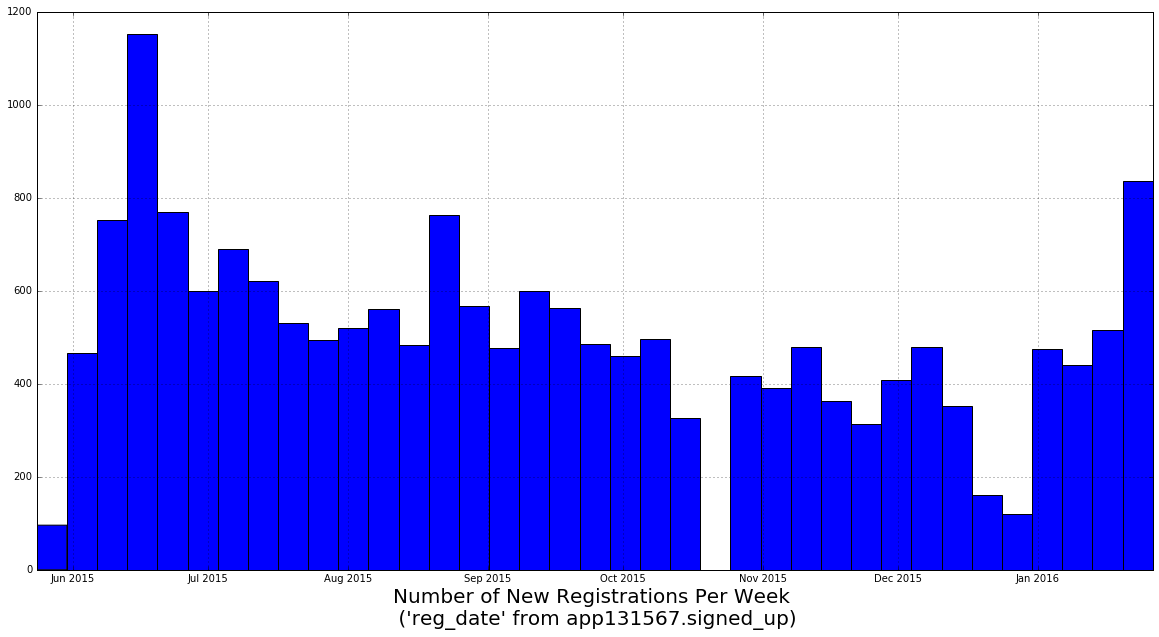

In [27]:
plt.figure(figsize=(20,10))
df_signups['reg_week'].hist(bins = len(df_signups['reg_week'].unique()))

plt.xlabel('Number of New Registrations Per Week \n (\'reg_date\' from app131567.signed_up)', size=20)

In [31]:
df_signups.to_csv(path+'UserRegistrationDate.csv')